In [1]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [4]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

In [5]:
#relevant cut for each stream
cuts1 = pd.read_csv("cuts/cuts.csv")
cuts2 = pd.read_csv("cuts/cuts2.csv")

cuts = cuts1.append(cuts2, ignore_index = True, sort = True)

#### let us write a function to extract the Gaia noise points based on some inputs

In [6]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

#### Let us define our potential models here

In [7]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#### For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars that we expect after applying an isochrone filter.
#### - This ratio was previously determined to be ~400

In [8]:
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

In [9]:
viable_streams = []

for i in cuts.stream_file:
    table = Table.read(i, format='fits')
    stream = table.to_pandas()
    
    idx = cuts.index[cuts.stream_file==str(i)][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream2 = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))
    
    if len(stream2) < 500:
        viable_streams.append(i)

####ONLY NEED TO RUN THIS ONCE
# test2 = obtain_test_set(viable_streams,400)

In [14]:
viable_new = viable_streams[:3]+viable_streams[5:]

#### Train a KNN model

In [15]:
def knn_simulated_stream(stream_name, k_optimal, multiple, train_ratio):

    table = Table.read(stream_name, format='fits')
    stream = table.to_pandas()
    
    idx = cuts.index[cuts.stream_file==stream_name][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

    #label our data as "part of the stream"
    stream['stream_mask'] = True

    #split data into training and training data set
    msk = np.random.rand(len(stream)) < train_ratio
    stream_train = stream[msk]
    stream_test = stream[~msk]


    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    name = "noise_points/" + stream_name[18:-8] + "_mul_400_total_noise.csv"
    noise_points = pd.read_csv(name)
    train_points = len(stream_train) * multiple

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    noise_test = noise_points[~msk2]
    
    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        
    return precision, recall, accuracy, auc, y_pred, y_true


#### we try a combination of hyperparameters and record their vote

In [16]:
res1 = pd.read_csv('fixed_test_ratio_results.csv', index_col = 0)
res2 = pd.read_csv('fixed_test_ratio_results2.csv', index_col = 0)
res = res1.append(res2, ignore_index = True)

res['f1']= 2*(res.precision * res.recall)/(res.precision + res.recall)
#res.sort_values(by = 'f1',ascending = False).head(20)
#res.query('f1 > 0.701')
res3 = res.groupby(['k','multiple','training_ratio']).mean().sort_values(by = 'f1',ascending = False)
res3 = res3.reset_index()[['k','multiple','training_ratio']]
tuples_try = [(list(res3.k)[i], list(res3.multiple)[i], list(res3.training_ratio)[i]) for i in range(75)]

In [23]:
tuples_try[:2]
len(tuples_try)
tuples_try

[(5, 376, 0.2),
 (3, 301, 0.2),
 (3, 326, 0.2),
 (4, 351, 0.2),
 (3, 276, 0.2),
 (4, 326, 0.2),
 (1, 376, 0.2),
 (2, 276, 0.2),
 (3, 251, 0.2),
 (5, 226, 0.2),
 (5, 276, 0.2),
 (5, 351, 0.2),
 (5, 251, 0.2),
 (5, 326, 0.2),
 (3, 351, 0.2),
 (3, 226, 0.2),
 (5, 301, 0.2),
 (3, 376, 0.2),
 (4, 276, 0.2),
 (4, 251, 0.2),
 (4, 201, 0.2),
 (4, 176, 0.2),
 (4, 226, 0.2),
 (3, 201, 0.2),
 (1, 351, 0.2),
 (1, 326, 0.2),
 (2, 226, 0.2),
 (2, 376, 0.2),
 (2, 201, 0.2),
 (4, 376, 0.2),
 (1, 301, 0.2),
 (3, 376, 0.1),
 (2, 151, 0.2),
 (2, 301, 0.2),
 (2, 351, 0.2),
 (5, 201, 0.2),
 (4, 301, 0.2),
 (2, 176, 0.2),
 (5, 176, 0.2),
 (2, 126, 0.2),
 (3, 176, 0.2),
 (2, 326, 0.2),
 (4, 126, 0.2),
 (2, 251, 0.2),
 (3, 276, 0.1),
 (3, 301, 0.1),
 (1, 226, 0.2),
 (2, 351, 0.1),
 (1, 276, 0.2),
 (5, 151, 0.2),
 (1, 201, 0.2),
 (1, 251, 0.2),
 (1, 351, 0.1),
 (4, 151, 0.2),
 (2, 326, 0.1),
 (3, 251, 0.1),
 (1, 326, 0.1),
 (3, 226, 0.1),
 (5, 326, 0.1),
 (2, 176, 0.1),
 (2, 151, 0.1),
 (1, 176, 0.2),
 (5, 251

In [18]:
results = {}


for stream_name in viable_new:
    table = Table.read(stream_name, format='fits')
    stream = table.to_pandas()

    idx = cuts.index[cuts.stream_file==stream_name][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

    #label our data as "part of the stream"
    stream['stream_mask'] = True
    
    votes = []
    
    number_of_votes = 25
    for voter in tqdm(tuples_try[:number_of_votes]):

        k_optimal = voter[0]
        multiple = voter[1]
        training_ratio = voter[2]
        
        
        #split data into training and training data set
        stream_train, stream_test = train_test_split(stream, test_size=1-training_ratio)

        #msk = np.random.rand(len(stream)) < training_ratio
        #stream_train = stream[msk]
        #stream_test = stream[~msk]


        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        name = "noise_points/" + stream_name[18:-8] + "_mul_400_total_noise.csv"
        noise_points = pd.read_csv(name)
        train_points = len(stream_train) * multiple
        
        noise_train = noise_points.sample(n=train_points,random_state = 25)
        leftover_noise = pd.concat([noise_points,noise_train]).drop_duplicates(keep=False)
        n_points = round(len(noise_points)*0.1)
        noise_test = leftover_noise.sample(n=n_points,random_state = 25)
        
        #ratio2 = train_points / len(noise_points)
        #noise_train, noise_test = train_test_split(noise_points, test_size= ratio2)
        #msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        #noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        #differentiate training and test data's X and y variables
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_train = training_data.stream_mask

        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_test = testing_data.stream_mask

        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_test).transform(X_test)

        precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        votes.append(y_pred)
        
    for i in range(len(votes)):
        name_of_vote = 'voter_' + str(i)
        testing_data[name_of_vote] = votes[i]
    
        #trouble_shooting
        #print(len(y_pred), len(stream_train), len(noise_points), train_points, len(noise_train), len(noise_test), len(leftover_noise))
    
    results[stream_name]=testing_data

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


In [19]:
results_use = copy.deepcopy(results)
streams = list(results_use.keys())

threshold = 0.2
for stream in streams:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec','stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    results_use[stream]['agg_vote'] = np.where(results_use[stream].avg_of_votes > threshold, True, False)

In [20]:
results_use[streams[1]].head(10)

,ra,dec,pmra,pmdec,stream_mask,voter_0,voter_1,voter_2,voter_3,voter_4,...,voter_17,voter_18,voter_19,voter_20,voter_21,voter_22,voter_23,voter_24,avg_of_votes,agg_vote
44,222.224900,-33.546458,0.066230,-1.439182,True,False,False,True,False,True,...,False,False,True,False,True,False,True,True,0.48,True
1,269.530570,-60.395395,-1.754759,-0.342596,True,False,True,False,False,False,...,True,True,True,False,True,True,True,False,0.52,True
280,230.804381,-42.848830,-1.219441,-1.637903,True,False,False,True,False,True,...,False,False,False,False,True,True,False,False,0.36,True
179,326.538887,-54.295980,0.452692,0.461862,True,False,True,True,True,False,...,False,False,False,False,False,True,True,False,0.32,True
155,289.770947,-61.856223,0.440813,-0.296346,True,True,True,False,False,True,...,False,False,False,True,False,False,True,True,0.44,True
22,308.688268,-59.454178,0.362730,-0.634997,True,False,True,True,True,True,...,False,False,False,True,False,False,False,True,0.48,True
52,299.618626,-60.950153,0.863050,-0.472146,True,False,False,True,False,False,...,False,False,False,False,False,False,True,True,0.28,True
184,291.809971,-61.599049,-0.439128,-1.544187,True,False,True,True,True,False,...,True,False,True,False,True,True,True,False,0.52,True
5,224.992884,-37.418428,1.335268,-0.388424,True,False,True,True,False,False,...,True,False,True,True,False,False,True,False,0.32,True
53,246.414322,-53.841063,1.223324,-1.301465,True,False,False,True,False,True,...,True,True,False,False,True,True,True,True,0.64,True


Number of true positives is 97
Number of false positives is 0
Number of true negatives is 4960
Number of false negatives is 3


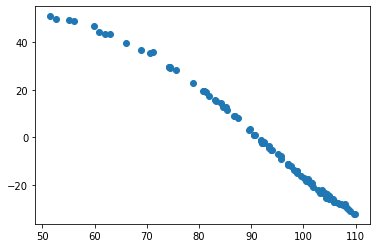

In [36]:
#Plot performance for Stream in index from 0 to len(streams)
stream_index = 5
y_test = results_use[streams[stream_index]].stream_mask
y_pred = results_use[streams[stream_index]].agg_vote
#Truly in Cluster
X_correct = results_use[streams[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
X_incorrect = results_use[streams[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
#Truly not in Cluster
X2_correct = results_use[streams[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
X2_incorrect = results_use[streams[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)

X_correct['label']=1
X_incorrect['label']=1
X2_correct['label']=0
X2_incorrect['label']=0

#visualize true and false positives
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])


#plt.scatter(X2_correct['pmra'], X2_correct['pmdec'])
#plt.scatter(X_incorrect['pmra'], X_incorrect['pmdec'])

#This takes true positives and false positives
X_pred_pos = X_correct.append(X2_incorrect, ignore_index = False, sort = True)

print('Number of true positives is ' + str(len(X_correct)))
print('Number of false positives is ' + str(len(X2_incorrect)))
print('Number of true negatives is ' + str(len(X2_correct)))
print('Number of false negatives is ' + str(len(X_incorrect)))


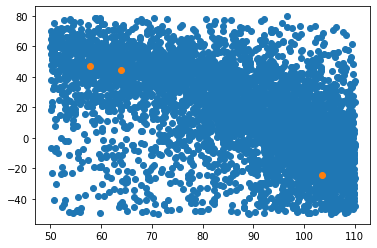

In [37]:
#visualize true and false positives
plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

#### Generate DataFrame of Results before generating confusion matrices

In [153]:
stream_name_ens = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []

for stream_index in range(len(viable_new)):
    y_test = results_use[streams[stream_index]].stream_mask
    y_pred = results_use[streams[stream_index]].agg_vote
    #Truly in Cluster
    X_correct = results_use[streams[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = results_use[streams[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = results_use[streams[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = results_use[streams[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)
    
    stream_name_ens.append(viable_new[stream_index])
    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    
final_result = pd.DataFrame()
final_result['stream']= stream_name_ens
final_result['true_positives']=true_positives
final_result['false_positives']=false_positives
final_result['true_negatives']=true_negatives
final_result['false_negatives']=false_negatives
final_result['precision'] = final_result.true_positives / (final_result.true_positives + final_result.false_positives)
final_result['recall'] = final_result.true_positives / (final_result.true_positives + final_result.false_negatives)
final_result['f1'] = 2*(final_result.precision * final_result.recall)/(final_result.precision + final_result.recall)

In [154]:
final_result

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1
0,gaia_mock_streams/stream-178.fits.gz,379,0,18960,1,1.000000,0.997368,0.998682
1,gaia_mock_streams/stream-9528.fits.gz,84,0,4240,1,1.000000,0.988235,0.994083
2,gaia_mock_streams/stream-1954.fits.gz,129,0,8000,31,1.000000,0.806250,0.892734
3,gaia_mock_streams/stream-4682.fits.gz,264,0,13160,0,1.000000,1.000000,1.000000
4,gaia_mock_streams/stream-5402.fits.gz,154,1,7679,0,0.993548,1.000000,0.996764
5,gaia_mock_streams/stream-3526.fits.gz,92,0,4960,8,1.000000,0.920000,0.958333
6,gaia_mock_streams/stream-9164.fits.gz,215,0,10720,0,1.000000,1.000000,1.000000
7,gaia_mock_streams/stream-2985.fits.gz,247,0,12320,0,1.000000,1.000000,1.000000


In [107]:
X = X_pred_pos[['ra', 'dec', 'pmra', 'pmdec']]
y = X_pred_pos.label
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.33, random_state=42)

#training set to be used for all scenarios
X_train_all = X_train
y_train_all = y_train


precision_log, recall_log, accuracy_log, auc_log, y_pred_log, y_true_log = log_reg_model(X_train, X_test, y_train, y_test)
y_pred_log =list(y_pred_log)
y_test_l = list(y_test)

tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(X_test)):
    if y_pred[i] == 1 and y_test_l[i] == 1:
        tp += 1
    elif y_pred[i] == 1 and y_test_l[i] ==0:
        fp += 1
    elif y_pred[i] == 0 and y_test_l[i] == 0:
        tn += 1
    else:
        fn += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tp, fp, tn, fn, precision, recall
all we have here are true positives and false negatives
    

In [104]:
len(y_pred_log), sum(y_pred_log), len(y_test), sum(y_test)

(57, 53, 57, 37)

In [106]:
15/37, 15/19

(0.40540540540540543, 0.7894736842105263)

In [118]:
k_optimal = 7
multiple = 400
training_ratio = 0.2

for stream_name in viable_new[1:]:
    table = Table.read(stream_name, format='fits')
    stream = table.to_pandas()
    
    idx = cuts.index[cuts.stream_file==stream_name][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

    #label our data as "part of the stream"
    stream['stream_mask'] = True

    #split data into training and training data set
    msk = np.random.rand(len(stream)) < training_ratio
    stream_train = stream[msk]
    stream_test = stream[~msk]


    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    name = "noise_points/" + stream_name[18:-8] + "_mul_400_total_noise.csv"
    noise_points = pd.read_csv(name)
    train_points = len(stream_train) * multiple

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    noise_test = noise_points[~msk2]
    
    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
    X_correct = X_test[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = X_test[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = X_test[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = X_test[~y_test & y_pred] #predicted in cluster (false positive)

    X_correct['label']=1
    X_incorrect['label']=1
    X2_correct['label']=0
    X2_incorrect['label']=0
    
    #This takes true positives and false positives
    X_pred_pos = X_correct.append(X2_incorrect, ignore_index = False, sort = True)
    #print('Number of true positives is ' + str(len(X_correct)))
    #print('Number of false positives is ' + str(len(X2_incorrect)))
    #print('Number of true negatives is ' + str(len(X2_correct)))
    #print('Number of false negatives is ' + str(len(X_incorrect)))

    true_positives = len(X_correct)
    false_positives = len(X2_incorrect)
    true_negatives = len(X2_correct)
    false_negatives = len(X_incorrect)
    
    print(true_positives, false_positives, true_negatives, false_negatives)
    
    X_test = X_pred_pos[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = X_pred_pos.label
    
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train_all, y_train_all)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    y_pred_log =list(y_pred)
    y_test_l = list(y_test)
    
    #print(len(X_pred_pos))
    #print(sum(y_pred))
    #print(sum(y_test_l))
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(X_test)):
        if y_pred[i] == 1 and y_test_l[i] == 1:
            tp += 1
        elif y_pred[i] == 1 and y_test_l[i] ==0:
            fp += 1
        elif y_pred[i] == 0 and y_test_l[i] == 0:
            tn += 1
        else:
            fn += 1
            
    true_positives = tp
    false_positives = fp
    true_negatives += tn
    false_negatives += fn
    
    print(true_positives, false_positives, true_negatives, false_negatives)
    print('-----end of stream--------')


19 16 34791 68
0 0 34807 87
-----end of stream--------
27 39 63505 132
0 0 63544 159
-----end of stream--------
129 79 105118 134
125 70 105127 138
-----end of stream--------
113 46 60001 37
0 0 60047 150
-----end of stream--------
33 19 39955 67
0 0 39974 100
-----end of stream--------
178 51 85160 35
1 2 85209 212
-----end of stream--------
133 59 100314 118
122 51 100322 129
-----end of stream--------


In [14]:
precisions = []
recalls = []
accuracies = []
aucs = []

names = []
k_vals = []
multiples = []
training_ratios = []

num_iters = len(viable_streams)*5*16*2
count = 0

#hyperparameter tuning / collation of results
for name in tqdm(viable_streams):
    for k in range(1,6):
        for multiple in range(1,400,25):
            for t_rat in range(1,3):
                precision, recall, accuracy, auc, y_pred, y_true = knn_simulated_stream(name, k, multiple, t_rat *.1)
                
                names.append(name)
                k_vals.append(k)
                multiples.append(multiple)
                training_ratios.append(0.1 * t_rat)
                
                precisions.append(precision)
                recalls.append(recall)
                accuracies.append(accuracy)
                aucs.append(auc)
                
                count += 1
                if count % 25 == 0:
                    print('calculation ' + str(count) + ' of ' + str(num_iters) + ' done...')
                

  0%|          | 0/10 [00:00<?, ?it/s]

calculation 25 of 1600 done...
calculation 50 of 1600 done...
calculation 75 of 1600 done...
calculation 100 of 1600 done...
calculation 125 of 1600 done...
calculation 150 of 1600 done...


 10%|█         | 1/10 [20:18<3:02:48, 1218.74s/it]

calculation 175 of 1600 done...
calculation 200 of 1600 done...
calculation 225 of 1600 done...
calculation 250 of 1600 done...
calculation 275 of 1600 done...
calculation 300 of 1600 done...


 20%|██        | 2/10 [27:20<2:10:36, 979.51s/it] 

calculation 325 of 1600 done...
calculation 350 of 1600 done...
calculation 375 of 1600 done...
calculation 400 of 1600 done...
calculation 425 of 1600 done...
calculation 450 of 1600 done...
calculation 475 of 1600 done...


 30%|███       | 3/10 [39:27<1:45:27, 903.90s/it]

calculation 500 of 1600 done...


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by StandardScaler.

In [15]:
df_results= pd.DataFrame()

df_results['stream_name'] = names
df_results['k'] = k_vals
df_results['multiple'] = multiples
df_results['training_ratio'] = training_ratios

df_results['precision']=precisions
df_results['recall'] = recalls
df_results['accuracy'] = accuracies
df_results['auc'] = aucs

df_results.to_csv('fixed_test_ratio_results.csv')

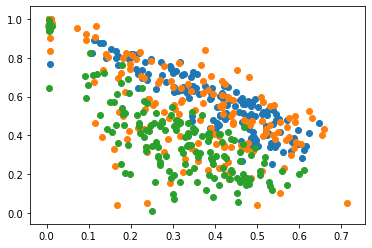

In [17]:
for i in range(3):
    df_test = df_results[df_results.stream_name == viable_streams[i]]
    plt.scatter(df_test.precision, df_test.recall)

In [89]:
viable_streams[1]

'gaia_mock_streams/stream-9528.fits.gz'

In [87]:
df_test1

,stream_name,k,multiple,training_ratio,precision,recall,accuracy,auc
0,gaia_mock_streams/stream-178.fits.gz,1,1,0.1,0.006832,0.934118,0.696045,0.814814
1,gaia_mock_streams/stream-178.fits.gz,1,1,0.2,0.009131,0.986877,0.785083,0.885777
2,gaia_mock_streams/stream-178.fits.gz,1,26,0.1,0.138202,0.832151,0.987989,0.910245
3,gaia_mock_streams/stream-178.fits.gz,1,26,0.2,0.113879,0.874317,0.986450,0.930493
4,gaia_mock_streams/stream-178.fits.gz,1,51,0.1,0.156700,0.817768,0.989310,0.903740
...,...,...,...,...,...,...,...,...
155,gaia_mock_streams/stream-178.fits.gz,5,326,0.2,0.507042,0.574468,0.997657,0.786568
156,gaia_mock_streams/stream-178.fits.gz,5,351,0.1,0.516129,0.405530,0.997597,0.702295
157,gaia_mock_streams/stream-178.fits.gz,5,351,0.2,0.546703,0.534946,0.997809,0.766937
158,gaia_mock_streams/stream-178.fits.gz,5,376,0.1,0.500000,0.298122,0.997522,0.648691


#### Let us visualize the precisions and recalls as we change our training_ratio and multiple

#### Consider we are interested in visualizing the model's predictions vs. the actual results. The following filters help visualize those results.

In [32]:
X_correct = X_test[y_test & y_pred]
X_incorrect = X_test[y_test & ~y_pred]

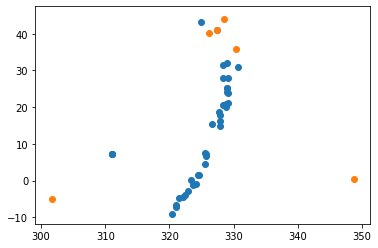

In [33]:
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

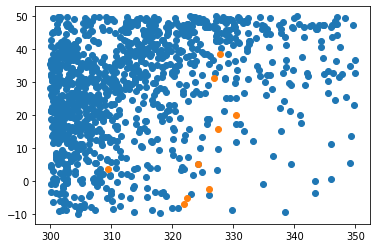

In [35]:
X2_correct = X_test[~y_test & ~y_pred]
X2_incorrect = X_test[~y_test & y_pred]

plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])

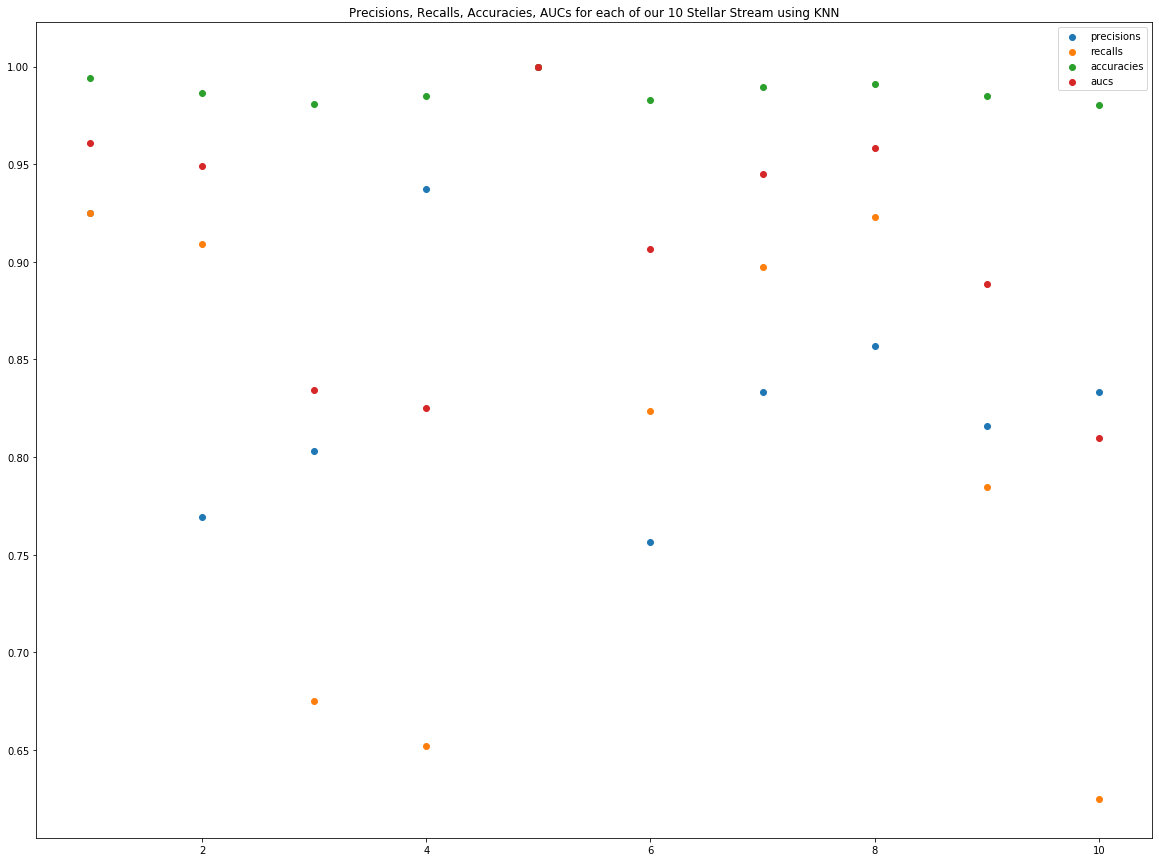

In [98]:
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(cuts)+1)]

plt.scatter(simulated_streams_index, precisions_simulated_knn, label = 'precisions')
plt.scatter(simulated_streams_index, recalls_simulated_knn, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated_knn, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated_knn, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(cuts)) + ' Stellar Stream using KNN')

plt.legend()

In [99]:
print('The average precision through KNN is: ' + str(sum(precisions_simulated_knn)/len(cuts)))
print('The average recall through KNN is: ' + str(sum(recalls_simulated_knn)/len(cuts)))
print('The average accuracy through KNN is: ' + str(sum(accuracy_simulated_knn)/len(cuts)))
print('The average AUC through KNN is: ' + str(sum(auc_simulated_knn)/len(cuts)))

The average precision through KNN is: 0.8531116826511564
The average recall through KNN is: 0.8215276416662981
The average accuracy through KNN is: 0.9875389641150127
The average AUC through KNN is: 0.9078559133379018
